In [14]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

random.seed(42)

PATH_TO_DATA = '../data/'

In [15]:
PATH_TO_TOP589_MAX3000 = PATH_TO_DATA + 'processed/dataset_full_top589_max3000.csv'
top589_max3000_df = pd.read_csv(PATH_TO_TOP589_MAX3000)
top589_max3000_df.tail(3)

,gbifID,eventDate,continent,country,stateProvince,decimalLatitude,decimalLongitude,scientificName,vernacularName,higherClassification,family,format,identifier
1388031,1955197315,2013-08-01,Europe,Netherlands,Zeeland,51.55,3.5,Zygaena filipendulae,Six-spot Burnet,Animalia|Zygaenidae,Zygaenidae,image/jpeg,https://observation.org/photos/5231846.jpg
1388032,4409413083,2021-07-19,Europe,Netherlands,Noord-Holland,52.40,5.0,Zygaena filipendulae,Six-spot Burnet,Animalia|Zygaenidae,Zygaenidae,image/jpeg,https://observation.org/photos/72072775.jpg
1388033,4410631543,2023-08-14,Europe,Netherlands,Limburg,50.95,5.9,Zygaena filipendulae,Six-spot Burnet,Animalia|Zygaenidae,Zygaenidae,image/jpeg,https://observation.org/photos/74877050.jpg


### Checking for multimodal training opportunities (+ location)

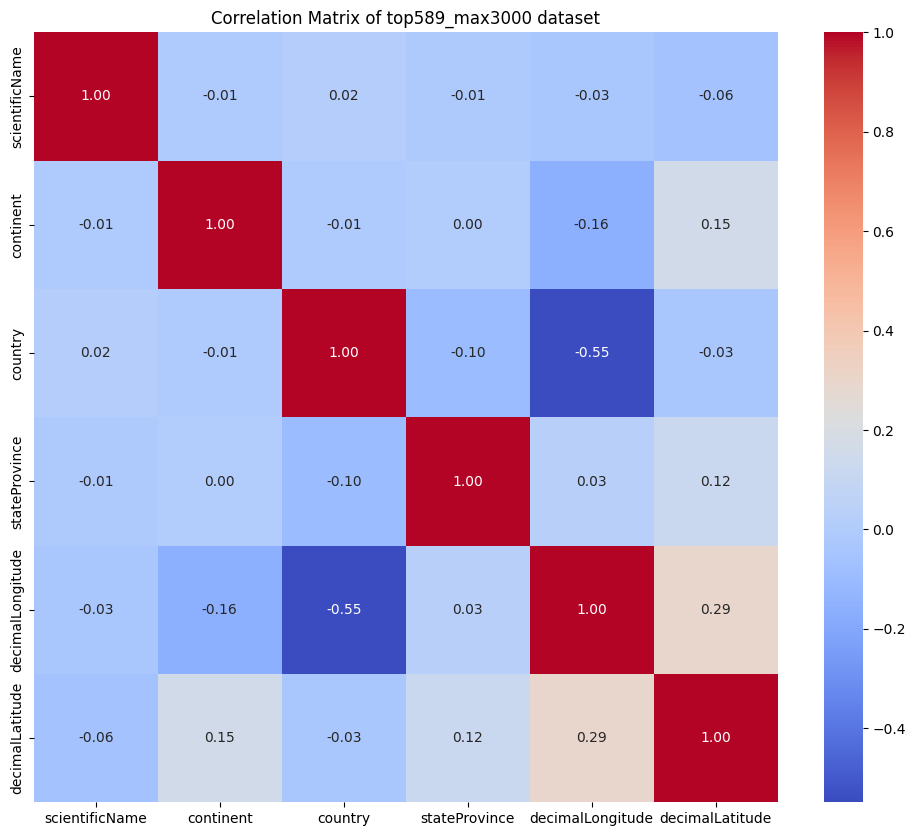

In [16]:
import warnings 
warnings.filterwarnings('ignore')

def create_correlation_matrix(df, title):
    label_encoder = LabelEncoder()

    # Encode categorical features automatically
    for column in df.columns:
        if df[column].dtype == 'object':  # Check if the column is categorical
            df[column] = label_encoder.fit_transform(df[column])

    corr_matrix = df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

top589_max3000_df_copy = top589_max3000_df

relevant_columns = ['scientificName', 'continent', 'country', 'stateProvince', 'decimalLongitude', 'decimalLatitude']

create_correlation_matrix(top589_max3000_df_copy[relevant_columns], 'Correlation Matrix of top589_max3000 dataset')

In [17]:
species_counts = top589_max3000_df['scientificName'].value_counts().index

continent_counts = []
country_counts = []
province_counts = []

for species in species_counts:
    one_species = top589_max3000_df[top589_max3000_df['scientificName'] == species]
    continentAmount = one_species['continent'].nunique()
    countriesAmount = one_species['country'].nunique()
    provincesAmount = one_species['stateProvince'].nunique()

    continent_counts.append((species, continentAmount))
    country_counts.append((species, countriesAmount))
    province_counts.append((species, provincesAmount))

continent_counts_df = pd.DataFrame(continent_counts, columns=['scientificName', 'continentCount'])
country_counts_df = pd.DataFrame(country_counts, columns=['scientificName', 'countryCount'])
province_counts_df = pd.DataFrame(province_counts, columns=['scientificName', 'provinceCount'])

# Merge DataFrames on 'scientificName'
counts_df = pd.merge(continent_counts_df, country_counts_df, on='scientificName')
counts_df = pd.merge(counts_df, province_counts_df, on='scientificName')

# Calculate and print the averages
average_continents = counts_df['continentCount'].mean()
average_countries = counts_df['countryCount'].mean()
average_provinces = counts_df['provinceCount'].mean()

print(f"On average every species is seen in {average_continents:.2f} continents, {average_countries:.2f} countries and {average_provinces:.2f} provinces.")

#counts_df.to_csv(PATH_TO_DATA + 'processed/analysis/dataset_top589_max3000_location_counts_per_species.csv', index=False)
counts_df.head(10)

On average every species is seen in 1.33 continents, 15.92 countries and 106.26 provinces.


,scientificName,continentCount,countryCount,provinceCount
0,Udea ferrugalis,2,20,131
1,Tyria jacobaeae,1,11,84
2,Zygaena filipendulae,1,9,78
3,Triodia sylvina,1,15,162
4,Acrobasis tumidana,1,11,51
5,Abrostola triplasia,1,7,46
6,Yponomeuta spec.,1,4,31
7,Acentria ephemerella,1,7,72
8,Aglais urticae,2,27,187
9,Aglais io,1,22,145


In [18]:
from pygbif import species

# Function to get synonyms using pygbif
def get_synonyms(scientific_name):
    result = species.name_backbone(name=scientific_name)
    if result['matchType'] == 'EXACT':
        species_key = result['usageKey']
        species_info = species.name_usage(key=species_key, data='synonyms')
        return species_info.get('results', [])
    return None

scientific_names = list(top589_max3000_df['scientificName'].unique())[0:10]

# Function to check if species are synonyms of each other
synonyms_dict = {}

for name in scientific_names:
    synonyms = get_synonyms(name)
    if synonyms:
        synonyms_dict[name] = set([' '.join(synonym['scientificName'].split(' ')[0:2]) for synonym in synonyms])
        
intersection = set(scientific_names).intersection(synonyms_dict[name])
if len(intersection) > 0:
    print(f'For the species "{name}" the following synonyms exist in the dataset: {list(intersection)}')

# List of scientific names (without authorities and years)

# Check for synonyms and print results


In [19]:
synonyms_dict.keys()

dict_keys(['Abraxas grossulariata', 'Abraxas sylvata', 'Abrostola triplasia', 'Acasis viretata', 'Acentria ephemerella', 'Acleris forsskaleana', 'Acleris notana/ferrugana', 'Acleris variegana', 'Acontia lucida', 'Acontia trabealis'])

In [20]:
synonyms_dict['Abraxas grossulariata']

{'Abraxas aberdoniensis',
 'Abraxas actinota',
 'Abraxas aenea',
 'Abraxas albipalliata',
 'Abraxas albispatiata',
 'Abraxas albomarginata',
 'Abraxas albovarleyata',
 'Abraxas alona',
 'Abraxas angustifasciata',
 'Abraxas antemarginata',
 'Abraxas ardana',
 'Abraxas aureofasciata',
 'Abraxas aureomarginata',
 'Abraxas aureopicta',
 'Abraxas aurivestita',
 'Abraxas axantha',
 'Abraxas basicaerulea',
 'Abraxas brevifasciata',
 'Abraxas candida',
 'Abraxas centralipuncta',
 'Abraxas chalcobares',
 'Abraxas chalcostrota',
 'Abraxas chalcozona',
 'Abraxas chrysostrota',
 'Abraxas cliftoniana',
 'Abraxas continua',
 'Abraxas crocea',
 'Abraxas croceolineata',
 'Abraxas cuneata',
 'Abraxas cuneifera',
 'Abraxas cupreofasciata',
 'Abraxas deleta',
 'Abraxas diluta',
 'Abraxas dohrnii',
 'Abraxas eremodisca',
 'Abraxas exquisita',
 'Abraxas flavipalliata',
 'Abraxas flavofasciata',
 'Abraxas formosa',
 'Abraxas fractifasciata',
 'Abraxas fulvapicata',
 'Abraxas gloriosa',
 'Abraxas hazeleighen

In [21]:
synonyms_dict['Abraxas sylvata']

{'Abraxas argyphea',
 'Abraxas bifasciata',
 'Abraxas circumnotata',
 'Abraxas confluens',
 'Abraxas fasciata',
 'Abraxas glomerata',
 'Abraxas guttata',
 'Abraxas intermedia',
 'Abraxas magnimaculata',
 'Abraxas nigrescens',
 'Abraxas nigrocellata',
 'Abraxas obscura',
 'Abraxas pantarioides',
 'Abraxas plumbea',
 'Abraxas purissima',
 'Abraxas radiata',
 'Abraxas reducta',
 'Abraxas rufomaculata',
 'Abraxas seminigra',
 'Abraxas striata',
 'Abraxas suffusa',
 'Abraxas transversa',
 'Abraxas ulmata',
 'Calospilos sylvata',
 'Calospilos ulmaria',
 'Geometra pantherata',
 'Phalaena sylvata',
 'Phalaena ulmata'}

In [22]:
# Filter the dataframe to include only rows where the higherClassification contains 'Geometridae' or 'Zygaenidae'
#moth_families = ['Geometridae', 'Zygaenidae', 'Tineidae']
moth_families = [
    "Noctuidae",
    "Psychidae",
    "Cossidae",
    "Sesiidae",
    "Yponomeutidae",
    "Zygaenidae",
    "Gelechiidae",
    "Geometridae",
    "Sphingidae",
    "Tortricidae",
    "Nepticulidae",
    "Pyralidae",
    "Saturniidae",
    "Limacodidae",
    "Hepialidae",
    "Arctiidae",
    "Lasiocampidae",
    "Tineidae",
    "Lymantriidae",
    "Thyrididae"
]

moth_species_df = top589_max3000_df_copy[top589_max3000_df_copy['family'].isin(moth_families)]

# Get the unique species count
unique_moth_species = moth_species_df['scientificName'].nunique()

print(f"Number of unique moth species: {unique_moth_species}")

Number of unique moth species: 331
